#STUDENT: ZRIBI JONATHAN

## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.

* **To be submitted by next session**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We provide you a pretrained model `VGG-16` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **VGG-16**: A deep architecture for image classification.

![vgg_16.png](https://www.researchgate.net/profile/Bibo_Shi/publication/323440752/figure/fig1/AS:739814685032448@1553396974148/The-architecture-of-VGG-16-model-To-represent-different-depth-levels-convolutional.jpg)

In [2]:
# The downloading process may take a few minutes. 
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course; notice that the images should be placed in a **sub**-directory of the path indicated below).<br>
In order to use the pretrained model vgg-16, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [3]:
# Define preprocessing function of the input images
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [4]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them
dir_path = "data/" 
dataset = preprocess_image(dir_path)

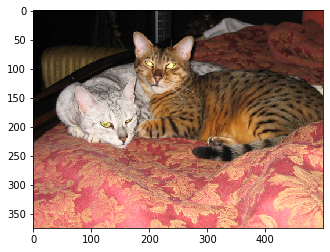

In [5]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

Predict the label of the input image, and print the top-3 possible classes

In [6]:
output = vgg_model(dataset[index][0].view(1, 3, 224, 224))

values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy())
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282]
Raw class scores: [17.41581  16.737848 15.801486]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model vgg-16 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. Run `print(vgg_model)` to get more information on VGG model.
 + The size of feature maps is 14x14, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

In [7]:
#print(vgg_model)
#last convolutional layer: 28th.

<h3>Helping Functions </h3>

In [8]:
import collections
from functools import partial

<h4>Resizing heatmap function </h4>

In [9]:
#Resizing of the heatmap at the end
#You need to project the heatmap to the resized image
#(224x224, not the original one, before the normalization) to have a better observation.
#14*14 to 224*224
def resize_heatmap(input, size):
    #size format : (x,y)
    input=input.unsqueeze(0)
    return nn.functional.interpolate(input,size)

<h4>Hook-based functions to save output and grad_output </h4>

In [10]:
#to avoid key error, we use collections.defaultdict(list) instead of the default python dictionnary.
dict_record_output=collections.defaultdict(list)
dict_record_grad=collections.defaultdict(list)

def record_out_map(layer_name,self,input,output):
    #print('record output: OK')
    #print('self: ', self)
    #print('layer name', layer_name)
    #print('Inside ' + self.__class__.__name__ + ' forward')
    dict_record_output[layer_name].append(output)
    #print('--')

def record_grad_map(layer_name,self, grad_input,grad_output):
    #print('record  grad_output: OK')
    #print('layer name: ',layer_name)
    dict_record_grad[layer_name].append(grad_output)

In [11]:
def hook_features_ouput(layer_name):
    return vgg_model.features[layer_name].register_forward_hook(partial(record_out_map,layer_name))

def hook_features_grad_output(layer_name):
    return vgg_model.features[layer_name].register_backward_hook(partial(record_grad_map,layer_name))

<h4>Backpropagation Function</h4>

In [12]:
def backward_one_class(output,class_number):
    output[:,class_number].backward()

<h4>Function to compute the importance of each pixel </h4>

In [13]:
#global-average-pooled 2 over the width and height dimensions (indexed by i and j)
def global_average_pool_grad(dict_record_output, dict_record_grad,layer_name=28):
    #activation_map size: 1, 512, 14, 14
    conv_layer_activations=dict_record_output[layer_name][0]
    #size of the gradient tensor is (1,512,14,14)
    alpha_importance_feature_map=torch.mean(dict_record_grad[layer_name][0][0],dim=[0,2,3])
    for feature_map_number in range(alpha_importance_feature_map.size()[0]):
        conv_layer_activations[:,feature_map_number,:,:]*=alpha_importance_feature_map[feature_map_number]
    #We make the sum over the feature maps
    weighted_combination= torch.sum(conv_layer_activations,dim=[1])
    return nn.functional.relu(weighted_combination)

<h4>Generate grad-cam visualization for one image and one class </h4>

In [14]:
#if necessary/problem:
#vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

In [15]:
def generate_grad_cam_one_image_one_class(index=5,class_number=285,layer_name=28):
    #output = vgg_model(dataset[index][0].view(1, 3, 224, 224))
    #handle.remove()
    layer_name=28
    class_number=285
    """Add the hooks"""
    handle1=hook_features_ouput(layer_name)
    handle2=hook_features_grad_output(layer_name)
    output = vgg_model(dataset[index][0].view(1, 3, 224, 224))
    backward_one_class(output,class_number)
    """Compute the global average pool gradient"""
    heatmap=global_average_pool_grad(dict_record_output, dict_record_grad,layer_name)
    """resize and normalize"""
    heatmap=resize_heatmap(heatmap,(224,224))
    heatmap/=torch.max(heatmap)
    heatmap=heatmap.squeeze()
    #Display the result
    #plt.matshow()
    plt_heatmap=heatmap.detach().numpy()
    """Cleaning"""
    handle1.remove()
    handle2.remove()
    dict_record_output[layer_name]=[]
    dict_record_grad[layer_name]=[]
    return plt_heatmap

<h3>Visualization Grad-Cam for One Image</h3>

If you want to visualize the grad-cam for one image, change the variable index. <br/>
The variable one_image should be equal to True to make the script running

In [16]:
index=5
one_image=True

Analysis of image :  6
loading...


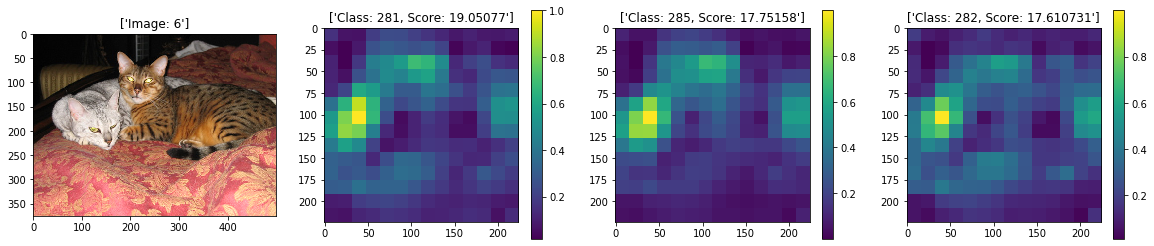

Done!


In [17]:
dict_heatmaps_numpy=collections.defaultdict(list)
fig = plt.figure(figsize=(20,100))
columns = 4
rows = 20
if one_image:
    for index in [index]: # range(number_images_to_analyze):
        print('Analysis of image : ', index+1)
        print('loading...')
        output = vgg_model(dataset[index][0].view(1, 3, 224, 224))
        values, indices = torch.topk(output, 3)
        #print('Image index : ', index)
        #print("Top 3-classes:", indices[0].numpy())
        #print("Raw class scores:", values[0].detach().numpy())
        ax1 = fig.add_subplot(rows, columns,4*index+1)
        ax1.set_title(['Image: '+str((index+1) )])
        #ax1.legend(loc="upper right")
        inputImage=Image.open(dataset.imgs[index][0]).convert('RGB')
        cax1 = ax1.imshow(inputImage)
        counter=1
        for class_number in indices[0].numpy():
            plt_heatmap=generate_grad_cam_one_image_one_class(index,class_number,layer_name=28)
            dict_heatmaps_numpy[index].append((class_number,plt_heatmap))
            ax = fig.add_subplot(rows, columns, 4*index+1+counter)
            ax.set_title(['Class: '+str(class_number)+', Score: '+str(values[0].detach().numpy()[counter-1])])
            cax = ax.imshow(plt_heatmap,cmap='viridis')
            fig.colorbar(cax, orientation='vertical')
            #ax.colorbar(cax, orientation='vertical')
            counter+=1
    plt.show()
    print('Done!')
else:
    print('Message: \n')
    print('Change the variable one_image if you want the results for ONE image')

<h3>Visualization Grad-Cam for ALL the Images (may take some time..)</h3>

If you want to visualize the grad-cam for ALL the images, <br/>
the variable all_images should be equal to True to make the script running

In [18]:
all_images=True

In [ ]:
dict_heatmaps_numpy=collections.defaultdict(list)
fig = plt.figure(figsize=(20,100))
columns = 4
rows = 20
#Change the below variable in order to display the result for a limited number of images
number_images_to_analyze=20
if all_images:
    for index in range(number_images_to_analyze):
        print('Analysis of image : ', index+1)
        print('loading...')
        output = vgg_model(dataset[index][0].view(1, 3, 224, 224))
        values, indices = torch.topk(output, 3)
        #print('Image index : ', index)
        #print("Top 3-classes:", indices[0].numpy())
        #print("Raw class scores:", values[0].detach().numpy())
        ax1 = fig.add_subplot(rows, columns,4*index+1)
        ax1.set_title(['Image: '+str((index+1) )])
        #ax1.legend(loc="upper right")
        inputImage=Image.open(dataset.imgs[index][0]).convert('RGB')
        cax1 = ax1.imshow(inputImage)
        counter=1
        for class_number in indices[0].numpy():
            plt_heatmap=generate_grad_cam_one_image_one_class(index,class_number,layer_name=28)
            dict_heatmaps_numpy[index].append((class_number,plt_heatmap))
            ax = fig.add_subplot(rows, columns, 4*index+1+counter)
            ax.set_title(['Class: '+str(class_number)+', Score: '+str(values[0].detach().numpy()[counter-1])])
            cax = ax.imshow(plt_heatmap,cmap='viridis')
            fig.colorbar(cax, orientation='vertical')
            counter+=1
    plt.show()
else:
    print('Message: \n')
    print('Change the variable all_image if you want the results for ALL the images')

Analysis of image :  1
loading...
Analysis of image :  2
loading...
Analysis of image :  3
loading...
Analysis of image :  4
loading...
Analysis of image :  5
loading...
Analysis of image :  6
loading...
Analysis of image :  7
loading...
Analysis of image :  8
loading...
Analysis of image :  9
loading...
Analysis of image :  10
loading...


<h3>Conclusion</h3>

* The Grad-Cam visualization is a relevant tool to understand what regions are the most important for a layer to assign a class
* In most cases, the regions with the distinguishing features of the animals are the high activated regions.
* The highlited regions for the prediction of a class of an image depend on the classification task. For example, regarding the image 7, the prediction for the class 279 is mainly based on the ears of the animal. However, it is less the case for the predictions for the classes 269 and 270.